In [90]:
print("Crutch to fix VSCode - product of small and poor company that cannot make Jupyter notebook run from first cell on first run, it runs from second on first launch and then runs from first (if using run all button)")

Crutch to fix VSCode - product of small and poor company that cannot make Jupyter notebook run from first cell on first run, it runs from second on first launch and then runs from first (if using run all button)


In [91]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
verbose = False
epsilon = 1e-5

def close_enough(A, B, epsilon=epsilon):
    return np.abs(A - B) < epsilon

def solve_linear_system(A, f, epsilon=epsilon): # Метод LU разложения
    N = len(f)
    
    L = np.zeros((N, N))
    U = np.zeros((N, N))

    for i in range(N):
        L[i][i] = 1

        for j in range(i, N):
            sum = 0
            for k in range(i):
                sum += L[i][k] * U[k][j]
            U[i][j] = A[i][j] - sum

        for j in range(i, N):
            sum = 0
            for k in range(i):
                sum += L[j][k] * U[k][i]
            L[j][i] = (A[j][i] - sum) / U[i][i]

    v = np.zeros(N)

    for i in range(N):
        v[i] = f[i]
        for j in range(i):
            v[i] -= L[i][j] * v[j]

    x = np.zeros(N)

    for i in range(N - 1, -1, -1):
        x[i] = v[i] / U[i][i]
        for j in range(i + 1, N):
            x[i] -= U[i][j] * x[j] / U[i][i]

    return x

def derivative(f, x, i, j, h=5e-5):
    x_1 = np.copy(x)
    x_1[j] += h
    x_2 = np.copy(x) 
    x_2[j] -= h
    return (f(x_1).ravel()[i] - f(x_2).ravel()[i]) / (2 * h)

def solve_newton(f, x, epsilon=epsilon, max_iterations=100):
    x = np.copy(x)
    original_shape = x.shape
    x = x.ravel()
        
    def f_flat(x):
        return f(x.ravel().reshape(original_shape)).ravel()
    
    N = len(f_flat(x))
        
    iterations = 0
    while not close_enough(np.sum(np.abs(f_flat(x.reshape(original_shape)))), 0):
        if iterations == max_iterations:
            raise ArithmeticError("Cannot solve system, too many iterations")
        iterations += 1
        J = np.array([[0.0] * N] * N)

        for i in range(N):
            for j in range(N):
                J[i][j] = derivative(f_flat, x, i, j)

        if verbose:
            print(J)
        
        delta_x = solve_linear_system(J, -f_flat(x), epsilon=epsilon)
        
        if np.sum(delta_x) == 0:
            raise ArithmeticError("Cannot solve system, delta x is zero")
        
        x = x + delta_x
        
        if verbose:
            print(f"x = {x}\ndelta_x = {delta_x}\nnorm = {np.sum(np.abs(f_flat(x.reshape(original_shape))))}")
    
    return x.reshape(original_shape)

################################################

class ButcherTable:
    def __init__(self, A):
        self.a = []
        self.c = []
        self.b = []
        
        self.s = len(A) - 1
        
        for i in range(self.s):
            self.a.append([])
            for j in range(self.s):
                self.a[i].append(A[i][j + 1])

            self.b.append(A[self.s][i + 1])
            
            self.c.append(A[i][0])

def solve_runge_kutta_explicit(tau, t, x, f, method, epsilon=epsilon):
    k = []
    for i in range(method.s):
        arg_1 = t + method.s * tau
        arg_2 = 0
        for j in range(i):
            arg_2 += method.a[i][j] * k[j]
        arg_2 *= tau
        arg_2 += x
        k.append(f(arg_1, arg_2))
    
    k = np.array(k)
        
    ret_val = x - x
    for i in range(method.s):
        ret_val += method.b[i] * k[i]
    ret_val *= tau
    ret_val += x
        
    return ret_val

def solve_runge_kutta_implicit(tau, t, x, f, method, epsilon=epsilon):
    def equation(k_0):
        k = []
        for i in range(method.s):
            arg_1 = t + method.s * tau
            arg_2 = 0
            for j in range(i):
                arg_2 += method.a[i][j] * k_0[j]
            arg_2 *= tau
            arg_2 += x
            k.append(f(arg_1, arg_2))
        
        k = np.array(k)
        return k - k_0
        
    k = solve_newton(equation, np.array([f(t, x) for _ in range(method.s)]), epsilon=epsilon)
        
    ret_val = x - x
    for i in range(method.s):
        ret_val += method.b[i] * k[i]
    ret_val *= tau
    ret_val += x
    
    return ret_val

################################################

def solve_adams_explicit(tau, t, x, f, N):
    if N > len(x):
        return solve_adams_explicit(tau, t, x, f, len(x))
    else:
        n = len(x) - 1
        match N:
            case 1:
                return x[n] + tau * f(t, x[n])
            case 2:
                return x[n] + tau * (3 * f(t, x[n]) - 1 * f(t, x[n - 1])) / 2
            case 3:
                return x[n] + tau * (23 * f(t, x[n]) - 16 * f(t, x[n - 1]) + 5 * f(t, x[n - 2])) / 12
            case 4:
                return x[n] + tau * (55 * f(t, x[n]) - 59 * f(t, x[n - 1]) + 37 * f(t, x[n - 2]) - 9 * f(t, x[n - 3])) / 24

def solve_adams_implicit(tau, t, x, f, N, epsilon=epsilon):
    if N > len(x):
        return solve_adams_implicit(tau, t, x, f, len(x))
    else:
        n = len(x) - 1
        match N:
            case 0:
                return solve_newton(lambda a: x[n] + tau * f(t, a) - a, x[n], epsilon=epsilon)
            case 1:
                return solve_newton(lambda a: x[n] + tau * (f(t, a) + f(t, x[n])) / 2 - a, x[n], epsilon=epsilon)
            case 2:
                return solve_newton(lambda a: x[n] + tau * (5 * f(t, a) + 8 * f(t, x[n]) - f(t, x[n - 1])) / 12 - a, x[n], epsilon=epsilon)
            case 3:
                return solve_newton(lambda a: x[n] + tau * (9 * f(t, a) + 19 * f(t, x[n]) - 5 * f(t, x[n - 1]) + f(t, x[n - 2])) / 24 - a, x[n], epsilon=epsilon)

################################################

def solve_backward_differentiation_explicit(tau, t, x, f, N):
    if N > len(x):
        return solve_backward_differentiation_explicit(tau, t, x, f, len(x))
    else:
        n = len(x) - 1
        match N:
            case 1:
                return x[n] + tau * f(t, x[n])
            case 2:
                return 2 / 3 * (tau * f(t, x[n]) - 1 / 2 * x[n - 1] + 2 * x[n])
            case 3:
                return 6 / 11 * (tau * f(t, x[n]) + 1 / 3 * x[n - 2] - 3 / 2 * x[n - 1] + 3 * x[n])
            case 4:
                return 12 / 25 * (tau * f(t, x[n]) - 1 / 4 * x[n - 3] + 4 / 3 * x[n - 2] - 3 * x[n - 1] + 4 * x[n])

def solve_backward_differentiation_implicit(tau, t, x, f, N, epsilon=epsilon):
    if N > len(x):
        return solve_backward_differentiation_implicit(tau, t, x, f, len(x), epsilon=epsilon)
    else:
        n = len(x) - 1
        match N:
            case 1:
                return solve_newton(lambda a: x[n] + tau * f(t, a) - a, x[n], epsilon=epsilon)
            case 2:
                return solve_newton(lambda a: 2 / 3 * (tau * f(t, a) - 1 / 2 * x[n - 1] + 2 * x[n]) - a, x[n] + (x[n] - x[n - 1]) / 2, epsilon=epsilon)
            case 3:
                return solve_newton(lambda a: 6 / 11 * (tau * f(t, a) + 1 / 3 * x[n - 2] - 3 / 2 * x[n - 1] + 3 * x[n]) - a, x[n] + (x[n] - x[n - 1]) / 2, epsilon=epsilon)
            case 4:
                return solve_newton(lambda a: 12 / 25 * (tau * f(t, a) - 1 / 4 * x[n - 3] + 4 / 3 * x[n - 2] - 3 * x[n - 1] + 4 * x[n]) - a, x[n] + (x[n] - x[n - 1]) / 2, epsilon=epsilon)


In [93]:
class Solution:
    def __init__(self, t, x, x_dot):
        self.t = t
        self.x = x
        self.x_dot = x_dot


def plot_solutions(solution_containers, multidimensionals_solution=False, parameter="order"):
    plt.figure(figsize=(12, 5))
    for solution_container in solution_containers:
        if multidimensionals_solution:
            for i in range(len(solution_container.solution.x[0])):
                plt.plot(solution_container.solution.t, [a[i] for a in solution_container.solution.x], label=f"{solution_container.name} ({parameter}: {solution_container.order}) ({i})") 
        else:
            plt.plot(solution_container.solution.t, solution_container.solution.x, label=f"{solution_container.name} ({parameter}: {solution_container.order})") 
    plt.xlabel("$t$")
    plt.ylabel("$x$")
    plt.title("Интегральные кривые")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    plt.show()
    
    if not multidimensionals_solution:
        plt.figure(figsize=(12, 5))
        for solution_container in solution_containers:
            plt.plot(solution_container.solution.x, solution_container.solution.x_dot, label=f"{solution_container.name} ({parameter}: {solution_container.order})")    
        plt.xlabel("$x$")
        plt.ylabel("$\\dot(x)$")
        plt.title("Фазовые траектории")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
        plt.show()


# Лабораторная работа 1 Системы ОДУ

$$ y'' + e (y^2 - 1)y'+ y = 0, e > 0, y(0) = 2, y'(0) = 0 $$
$$
    \begin{cases}
        x'= z \\
        z' = e(1-x^2) z - x \\
        x(0) = 2 \\
        z(0) = 0
    \end{cases}
$$

In [94]:
def f(t, x):
    return np.array([
        x[1],
        np.exp(1) * (1 - x[0] ** 2) * x[1] - x[0],
    ])

## Методы Рунге-Кутта
[Источник](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods)

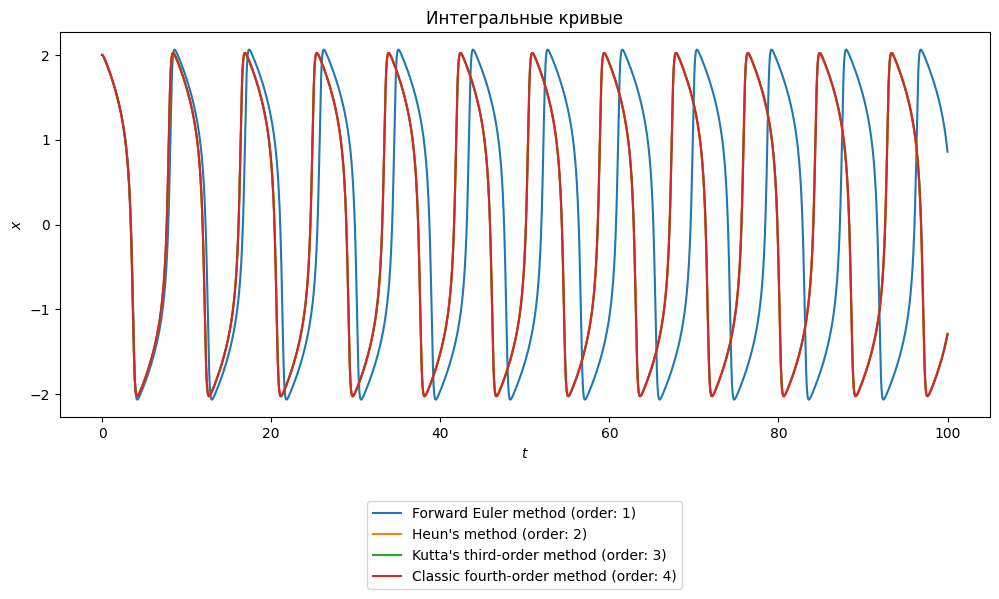

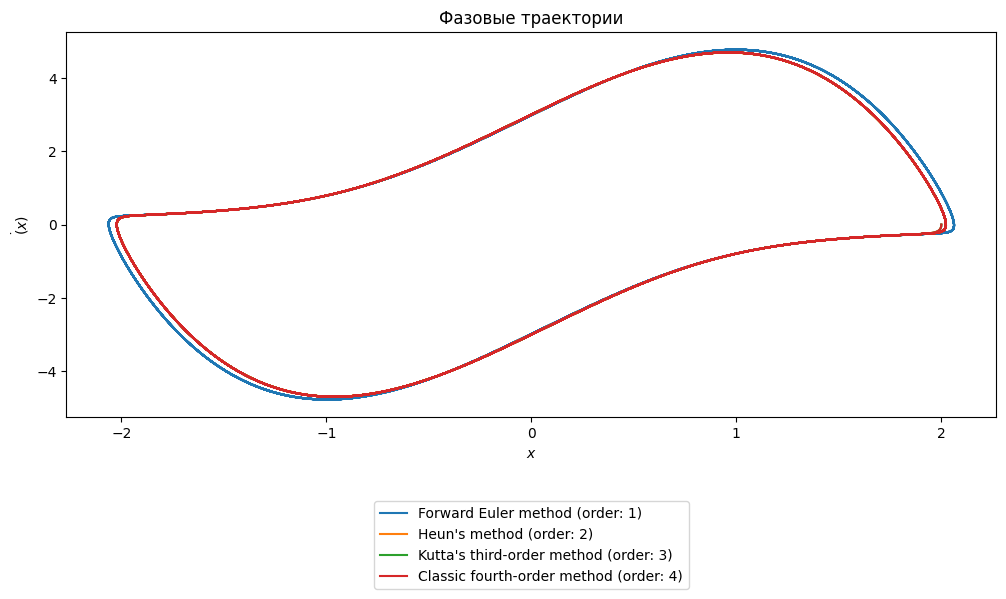

In [95]:
tau = 0.015
t_stop = 100

class RungeKuttaMethod:
    def __init__(self, name: str, order: int, table: ButcherTable):
        self.name = name
        self.order = order
        self.table = table
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[RungeKuttaMethod] = []

methods.append(
    RungeKuttaMethod(
        "Forward Euler method",
        1,
        ButcherTable(
            [
                [0.0, 0.0],
                [0.0, 1.0],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Heun's method",
        2,
        ButcherTable(
            [
                [0.0, 0.0, 0.0],
                [1.0, 1.0, 0.0],
                [0.0, 1/2, 1/2],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Kutta's third-order method",
        3,
        ButcherTable(
            [
                [0.0,  0.0, 0.0, 0.0],
                [1/2,  1/2, 0.0, 0.0],
                [1.0, -1.0, 2.0, 0.0],
                [0.0,  1/6, 2/3, 1/6],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Classic fourth-order method",
        4,
        ButcherTable(
            [
                [0.0, 0.0, 0.0, 0.0, 0.0],
                [1/2, 1/2, 0.0, 0.0, 0.0],
                [1/2, 0.0, 1/2, 0.0, 0.0],
                [1.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 1/6, 1/3, 1/3, 1/6],
            ]
        )
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([2.0, 0.0])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_runge_kutta_explicit(tau, t[i - 1], x[i - 1], f, method.table))
        i += 1
    
    method.set_solution(
        t, 
        np.array([a[0] for a in x]),
        np.array([a[1] for a in x]),
    )
    
plot_solutions(methods)


## Методы Адамса

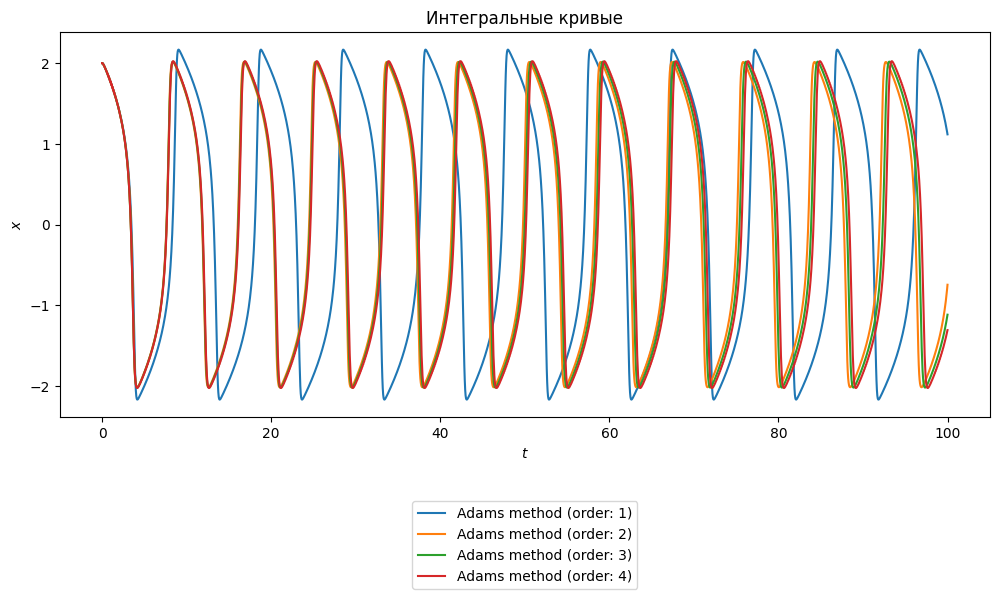

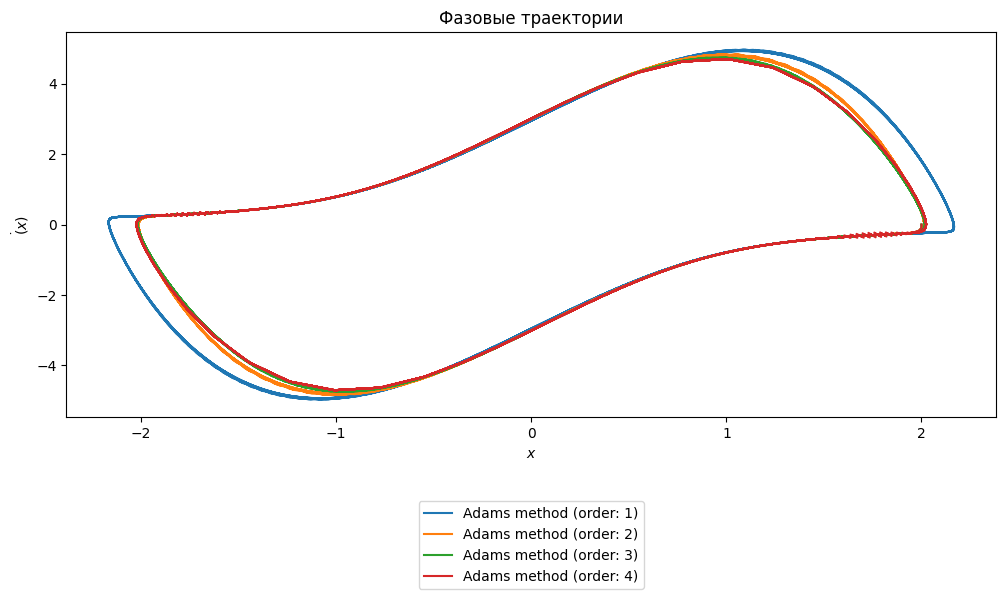

In [96]:
tau = 0.05
t_stop = 100

class AdamsMethod:
    def __init__(self, order: int):
        self.name = "Adams method"
        self.order = order
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[AdamsMethod] = []

methods.append(
    AdamsMethod(
        1,
    )
)

methods.append(
    AdamsMethod(
        2,
    )
)

methods.append(
    AdamsMethod(
        3,
    )
)

methods.append(
    AdamsMethod(
        4,
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([2.0, 0.0])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_adams_explicit(tau, t[i - 1], x, f, method.order))
        i += 1
    
    method.set_solution(
        t, 
        np.array([a[0] for a in x]),
        np.array([a[1] for a in x]),
    )
    
plot_solutions(methods)


## Явные методы дифференцирования назад

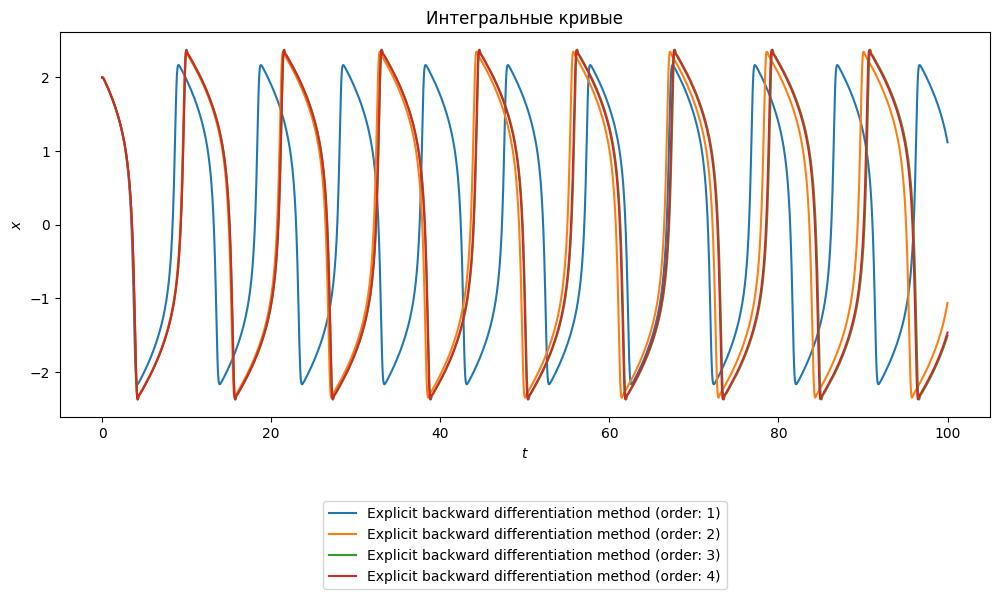

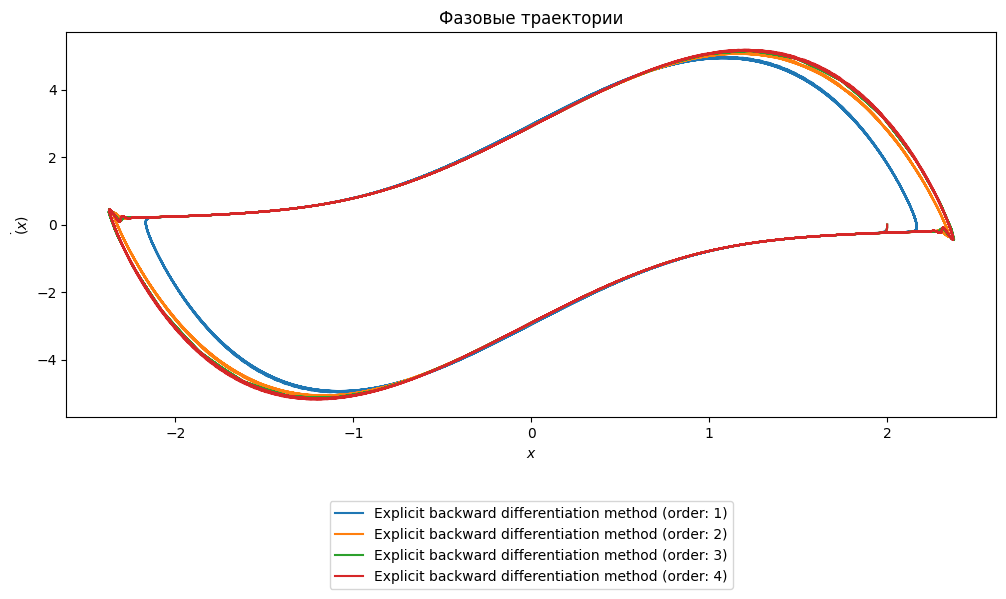

In [97]:
tau = 0.05
t_stop = 100
class ExplicitBackwardDiffenetiationMethod:
    def __init__(self, order: int):
        self.name = "Explicit backward differentiation method"
        self.order = order
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[ExplicitBackwardDiffenetiationMethod] = []

methods.append(
    ExplicitBackwardDiffenetiationMethod(
        1,
    )
)

methods.append(
    ExplicitBackwardDiffenetiationMethod(
        2,
    )
)

methods.append(
    ExplicitBackwardDiffenetiationMethod(
        3,
    )
)

methods.append(
    ExplicitBackwardDiffenetiationMethod(
        4,
    )
)

for method in methods:
    t = [0]
    i = 1
        
    x = [
        np.array([2.0, 0.0])
    ]

    
    while tau * i <= t_stop:
        t.append(tau * i)
        x.append(solve_backward_differentiation_explicit(tau, t[i - 1], x, f, method.order))
        i += 1
    
    method.set_solution(
        t, 
        np.array([a[0] for a in x]),
        np.array([a[1] for a in x]),
    )
    
plot_solutions(methods)


# Лабораторная работа 2 Системы ОДУ (жёсткий вариант)

$$
\begin{cases}
    \dot{y}_1 = 77.27 (y_2 + y_1 (1 - 8.375 \cdot 10^{-6} y_1 - y_2)) \\
    \dot{y}_2 = \frac{1}{77.27} (y_3 - (1 + y_1) y_2) \\
    \dot{y}_3 = 0.161 (y_1 - y_3)
\end{cases}
$$

In [98]:
def f(t, x):
    return np.array([
        77.27 * (x[1] + x[0] * (1 - 8.375e-6 * x[0] - x[1])),
        1 / 77.27 * (x[2] - (1 + x[0]) * x[1]),
        0.161 * (x[0] - x[2])
    ])

## Неявные методы Рунге-Кутта

Gauss-Legendre method (non-adaptive) 4
Cannot solve system, too many iterations
Failed to solve at t = 0.305


/tmp/ipykernel_41441/4205162948.py:39: RuntimeWarning: invalid value encountered in scalar divide
  L[j][i] = (A[j][i] - sum) / U[i][i]
/tmp/ipykernel_41441/4205162948.py:51: RuntimeWarning: invalid value encountered in scalar divide
  x[i] = v[i] / U[i][i]


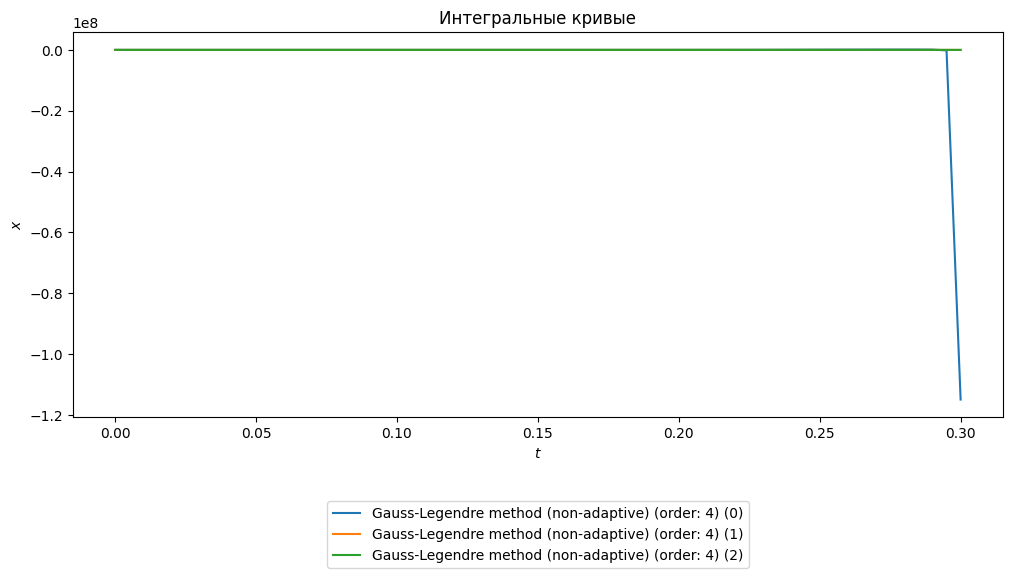

Classic fourth-order method 4


/tmp/ipykernel_41441/4205162948.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  L[j][i] = (A[j][i] - sum) / U[i][i]
/tmp/ipykernel_41441/4205162948.py:38: RuntimeWarning: invalid value encountered in scalar multiply
  sum += L[j][k] * U[k][i]
/tmp/ipykernel_41441/4205162948.py:32: RuntimeWarning: invalid value encountered in scalar multiply
  sum += L[i][k] * U[k][j]
/tmp/ipykernel_41441/4205162948.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  x[i] = v[i] / U[i][i]


Cannot solve system, too many iterations
Failed to solve at t = 0.26


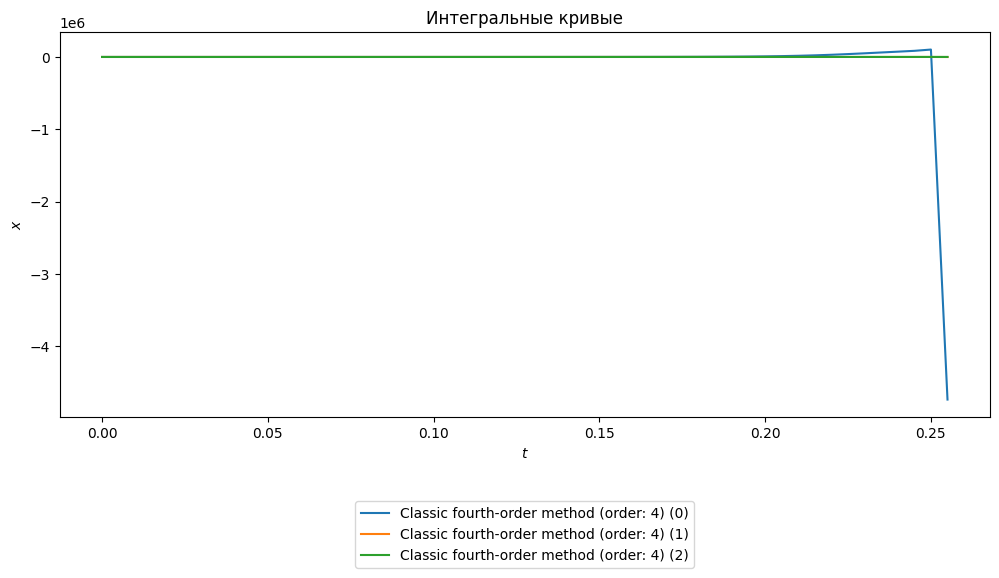

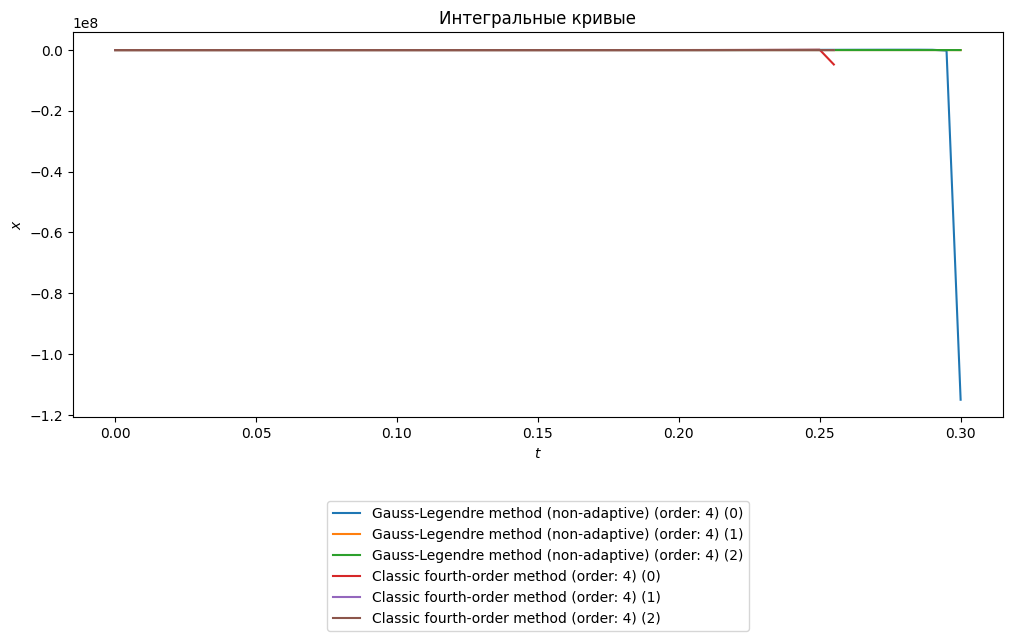

In [99]:
enabled = True

tau = 0.005
t_stop = 10
# t_stop = 2.4

methods: list[RungeKuttaMethod] = []

methods.append(
    RungeKuttaMethod(
        "Gauss-Legendre method (non-adaptive)",
        4,
        ButcherTable(
            [
                [1 / 2 - np.sqrt(3) / 6, 1 / 4                 , 1 / 4 - np.sqrt(3) / 6],
                [1 / 2 + np.sqrt(3) / 6, 1 / 4 + np.sqrt(3) / 6, 1 / 4                 ],
                [0                     , 1 / 2                 , 1 / 2                 ],
            ]
        )
    )
)

methods.append(
    RungeKuttaMethod(
        "Classic fourth-order method",
        4,
        ButcherTable(
            [
                [0.0, 0.0, 0.0, 0.0, 0.0],
                [1/2, 1/2, 0.0, 0.0, 0.0],
                [1/2, 0.0, 1/2, 0.0, 0.0],
                [1.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 1/6, 1/3, 1/3, 1/6],
            ]
        )
    )
)

if enabled:
    for method in methods:
        t = [0]
        i = 1
            
        x = [
            np.array([0.5, 0.5, 0.5])
        ]
        
        print(method.name, method.order)
        
        while tau * i <= t_stop:
            try:
                x.append(solve_runge_kutta_implicit(tau, t[i - 1], x[i - 1], f, method.table))
            except Exception as e:
                print(e)
                print(f"Failed to solve at t = {tau * i}")
                break
            
            t.append(tau * i)
            
            i += 1
            
            if verbose:
                print(tau * i)
            
        method.set_solution(
            t, 
            np.array(x),
            np.array(x),
        )
        
        plot_solutions([method], multidimensionals_solution=True)

    plot_solutions(methods, multidimensionals_solution=True)


## Неявные метода дифференцирования назад

Implicit backward differentiation method 1


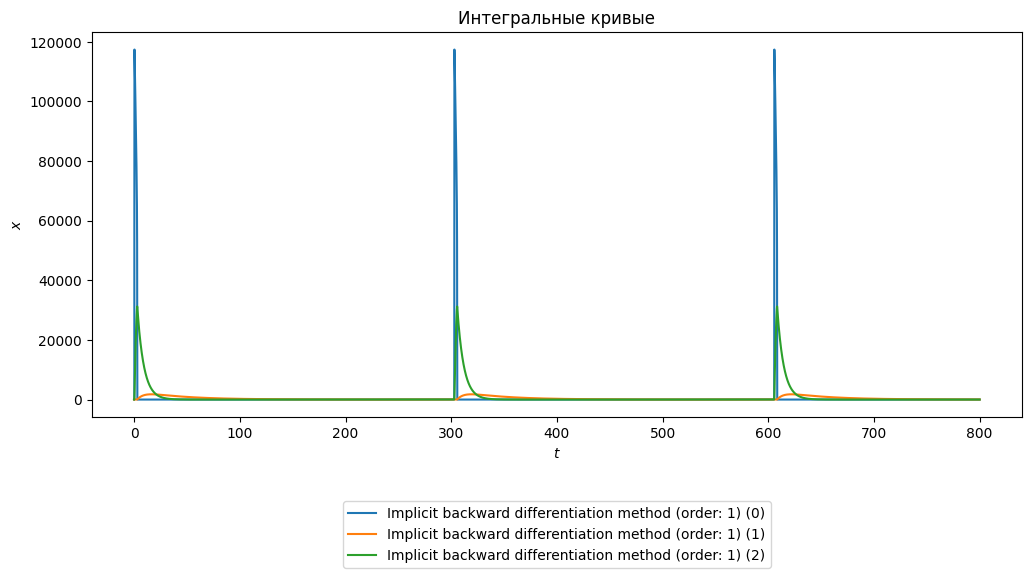

Implicit backward differentiation method 2


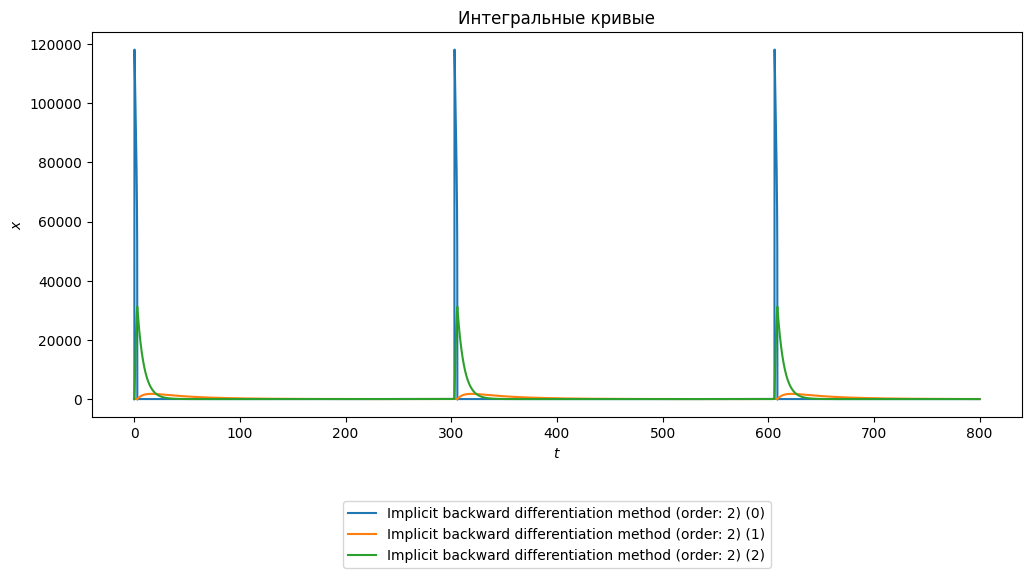

Implicit backward differentiation method 3


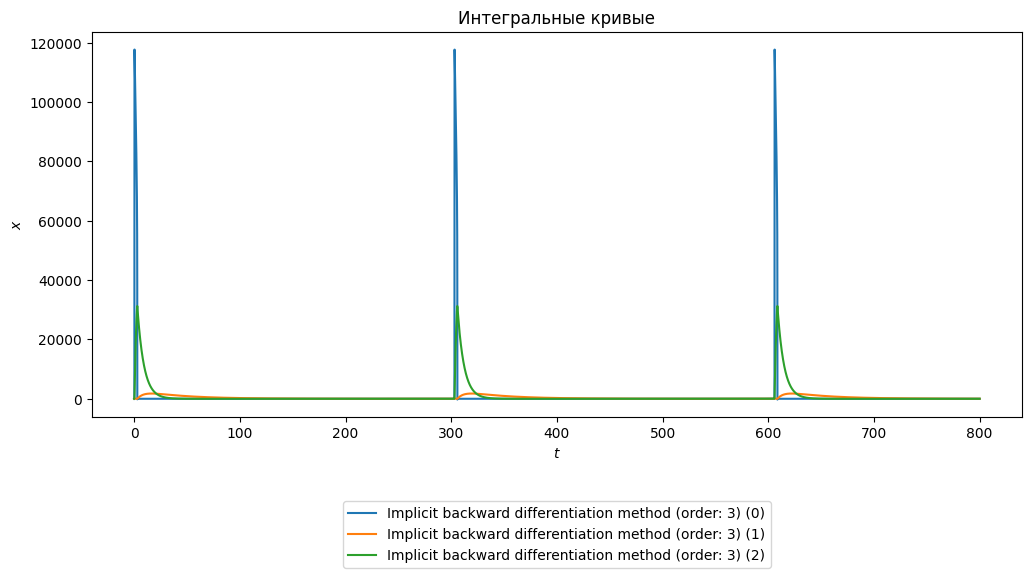

Implicit backward differentiation method 4


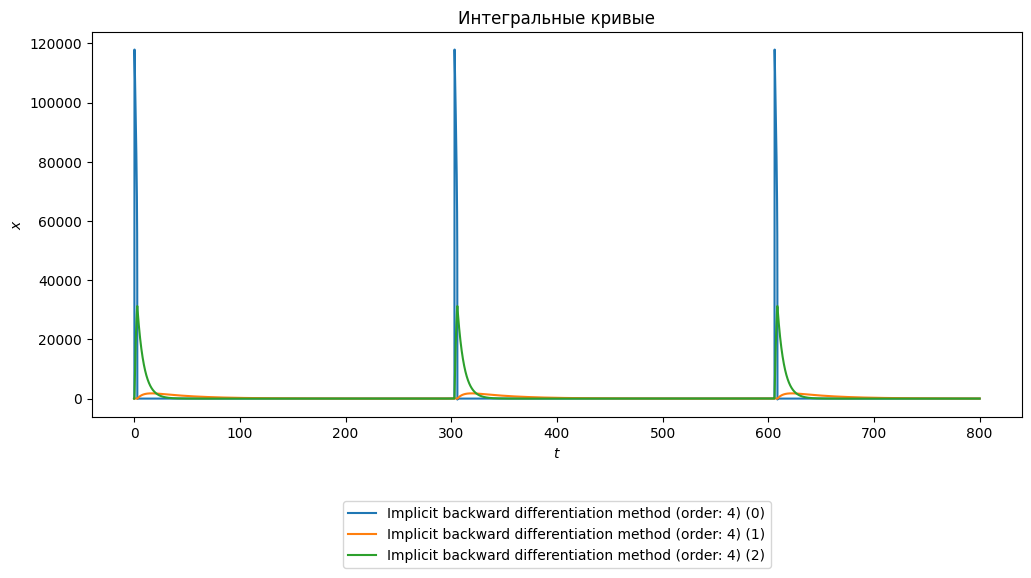

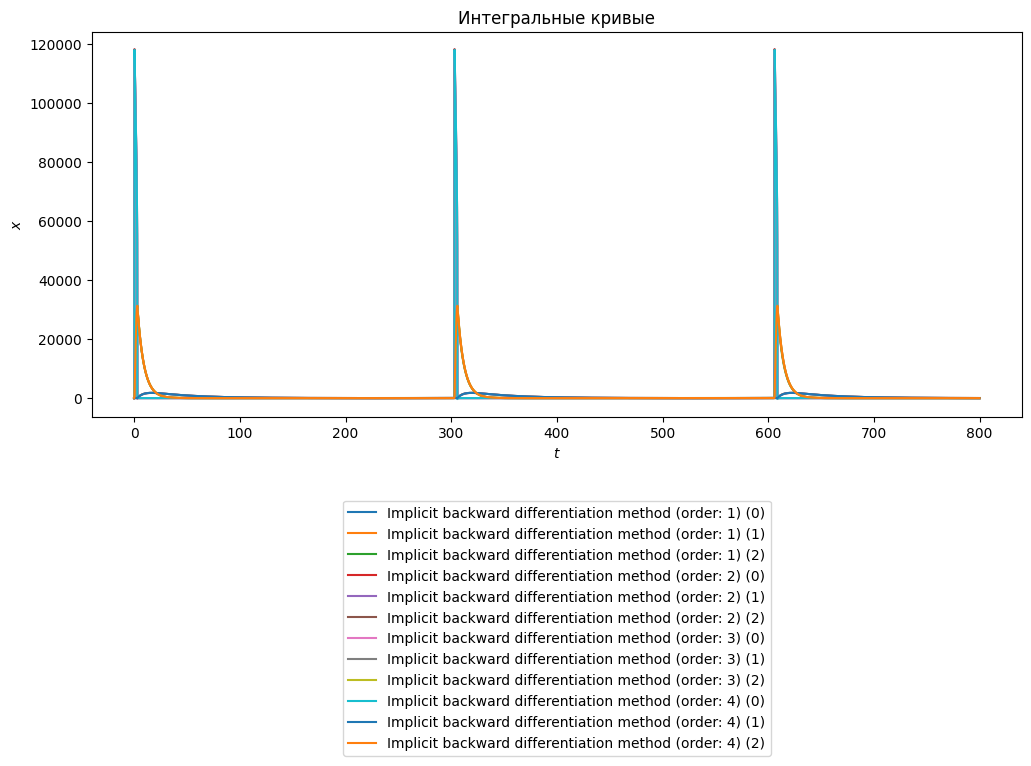

In [100]:
tau = 0.01
t_stop = 800

enabled = True

class ImplicitBackwardDiffenetiationMethod:
    def __init__(self, order: int):
        self.name = "Implicit backward differentiation method"
        self.order = order
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[ImplicitBackwardDiffenetiationMethod] = []

methods.append(
    ImplicitBackwardDiffenetiationMethod(
        1,
    )
)

methods.append(
    ImplicitBackwardDiffenetiationMethod(
        2,
    )
)

methods.append(
    ImplicitBackwardDiffenetiationMethod(
        3,
    )
)

methods.append(
    ImplicitBackwardDiffenetiationMethod(
        4,
    )
)

if enabled:
    for method in methods:
        
        t = [0]
        i = 1

        x = [
            np.array([0.5, 0.5, 0.5])
        ]

        print(method.name, method.order)
        
        while tau * i <= t_stop:
            try:
                x.append(solve_backward_differentiation_implicit(tau, t[i - 1], x, f, method.order))
            except Exception as e:
                print(e)
                print(f"Failed to solve at t = {tau * i}")
                break
            
            t.append(tau * i)
            
            i += 1
            
            if verbose:
                print(tau * i)
        
        method.set_solution(
            t, 
            np.array(x),
            np.array(x),
        )
        plot_solutions([method], multidimensionals_solution=True)
        
    plot_solutions(methods, multidimensionals_solution=True)

## Неявные методы Адамса

Методы Адамса высших порядков оказались нестабильными при различных шагах сетки

Implicit Adams method 0


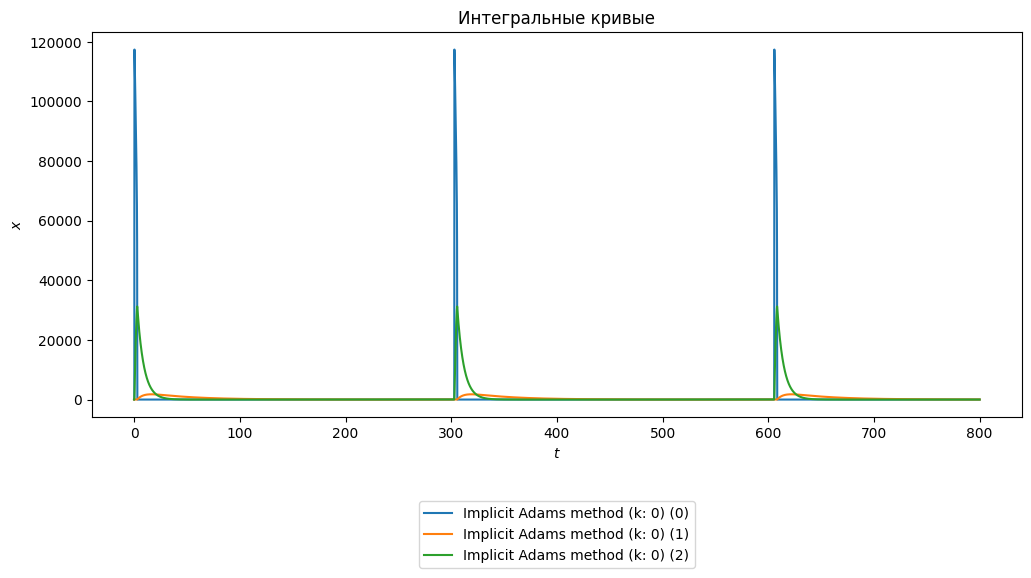

Implicit Adams method 1


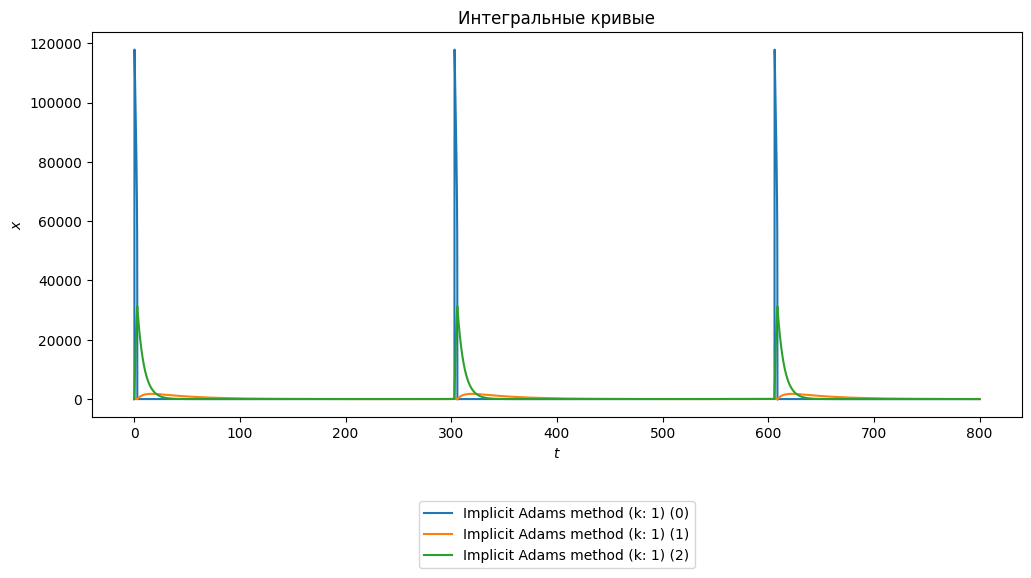

Implicit Adams method 2
Cannot solve system, too many iterations
Failed to solve at t = 0.58


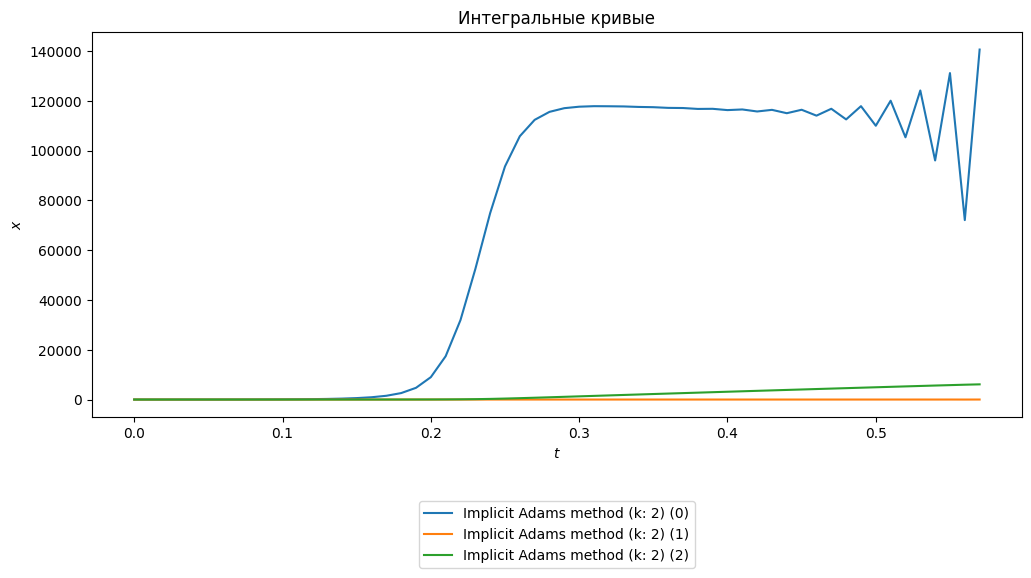

Implicit Adams method 3
Cannot solve system, too many iterations
Failed to solve at t = 0.42


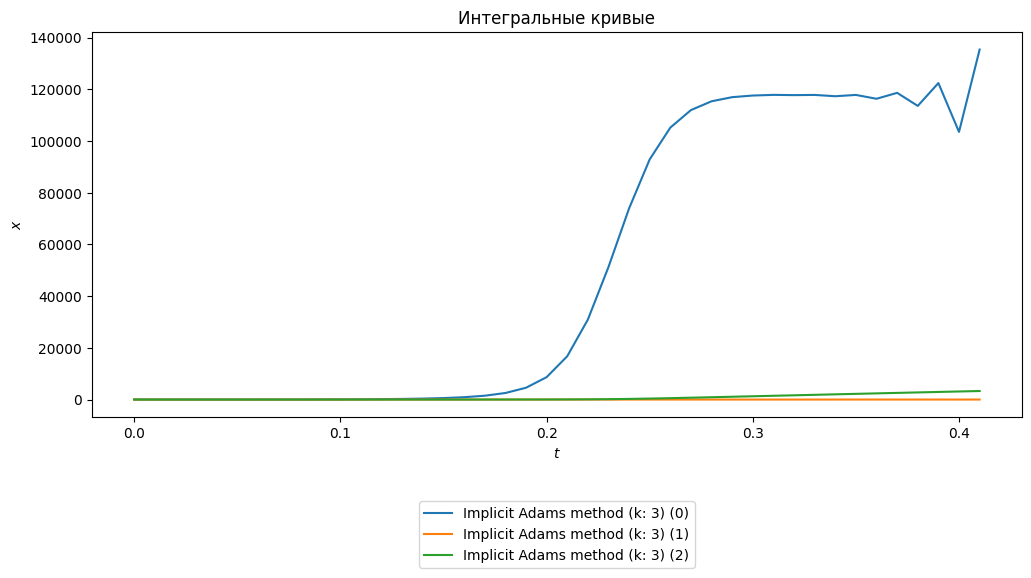

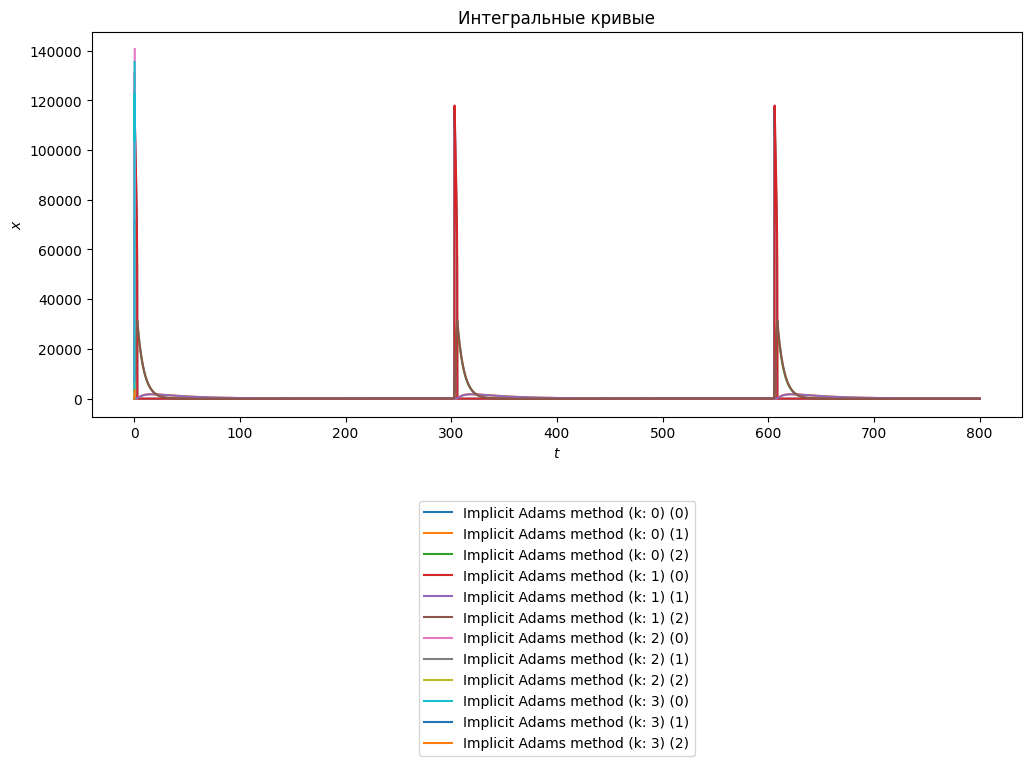

In [101]:
tau = 0.01
t_stop = 800

enabled = True

class ImplicitAdamsMethod:
    def __init__(self, order: int):
        self.name = "Implicit Adams method"
        self.order = order
        self.solution = None
    
    def set_solution(self, t, x, x_dot):
        self.solution = Solution(t, x, x_dot)

methods: list[ImplicitAdamsMethod] = []

methods.append(
    ImplicitAdamsMethod(
        0,
    )
)

methods.append(
    ImplicitAdamsMethod(
        1,
    )
)

methods.append(
    ImplicitAdamsMethod(
        2,
    )
)

methods.append(
    ImplicitAdamsMethod(
        3,
    )
)

if enabled:
    for method in methods:
        t = [0]
        i = 1

        x = [
            np.array([0.5, 0.5, 0.5])
        ]

        print(method.name, method.order)
        
        while tau * i <= t_stop:
            try:
                x.append(solve_adams_implicit(tau, t[i - 1], x, f, method.order))
            except Exception as e:
                print(e)
                print(f"Failed to solve at t = {tau * i}")
                break
            
            t.append(tau * i)
            
            i += 1
            
            if verbose:
                print(tau * i)
        
        method.set_solution(
            t, 
            np.array(x),
            np.array(x),
        )
        plot_solutions([method], multidimensionals_solution=True, parameter="k")
        
    plot_solutions(methods, multidimensionals_solution=True, parameter="k")

# Лабораторная работа 3 Линейная КУ

$$y''-P^2(x)y=f(x)$$
$$P^2(x) = 10 + sin(2 \pi x)$$
$$f(x) = cos(2 \pi x)$$

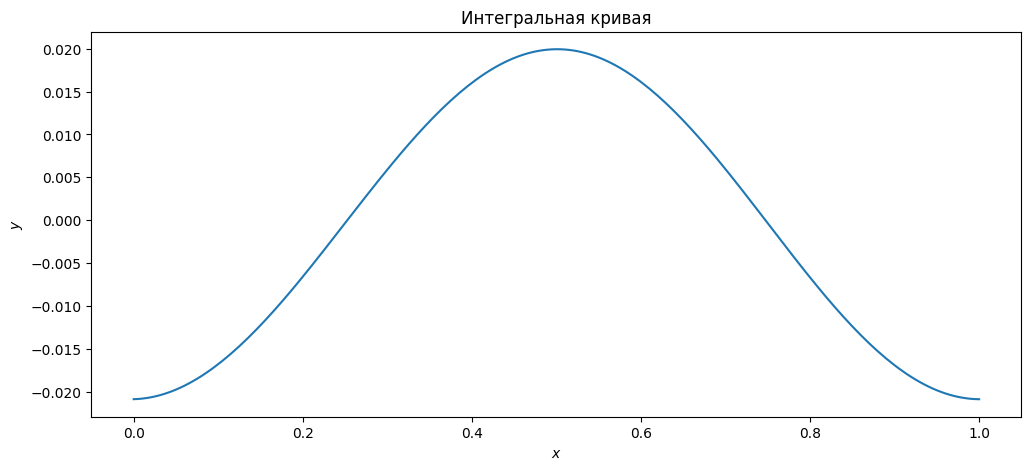

In [102]:
def f(x):
    return np.cos(2 * np.pi * x)

def P2(x):
    return 10 + np.sin(2 * np.pi * x)

h = 0.005

x_0 = 0
x_N = 1

N = int(np.round((x_N - x_0) / h)) + 1

A = np.zeros((N, N))
b = np.zeros(N)

for i in range(N):
    A[i][(i + 1) % N] = 1 / h**2
    A[i][(i + 0) % N] = -2 / h**2 - P2(i * h)
    A[i][(i - 1) % N] = 1 / h**2
    
    b[i] = f(i * h)

for i in range(1, N):
    b[i] -= b[i - 1] * A[i][i - 1] / A[i - 1][i - 1]
    A[i] -= A[i - 1] * A[i][i - 1] / A[i - 1][i - 1]

for i in range(0, N - 1):
    b[N - 1] -= b[i] * A[N - 1][i] / A[i][i]
    A[N - 1] -= A[i] * A[N - 1][i] / A[i][i]

for i in range(0, N - 1):
    b[i] -= b[N - 1] * A[i][N - 1] / A[N - 1][N - 1]
    A[i] -= A[N - 1] * A[i][N - 1] / A[N - 1][N - 1]

for i in range(N - 2, -1, -1):
    b[i] -= b[i + 1] * A[i][i + 1] / A[i + 1][i + 1]
    A[i] -= A[i + 1] * A[i][i + 1] / A[i + 1][i + 1]

for i in range(N):
    b[i] /= A[i][i]

plt.figure(figsize=(12, 5))
plt.plot(np.linspace(x_0, x_N, N), b) 
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Интегральная кривая")
plt.show()
